## 1. Importing necessary parts

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt

In [50]:
torch.__version__

'2.6.0+cu124'

In [51]:
torchvision.__version__

'0.21.0+cu124'

In [52]:
!nvidia-smi

Wed Jul  9 08:01:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P0             26W /   70W |     338MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 2. Setup Device-Agonitstic Code

In [53]:
torch.cuda.is_available()

True

In [54]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [55]:
print(f"Using Device: {device}")

Using Device: cuda


## 3. Set the seed

In [56]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

In [57]:
## 4. Setting Hyperparameters

In [58]:
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 3e-4
PATCH_SIZE = 4
NUM_CLASSES = 10
IMAGE_SIZE = 32
CHANNELS = 3
EMBED_DIM = 256
NUM_HEADS = 8
DEPTH = 6
MLP_DIM = 512
DROP_RATE = 0.1

## 5. Define Image Transformations

In [59]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
    # Helps the model to convert faster
    # Helps to make the numerical computations stable
])

## 6. Getting a Dataset

In [60]:
train_dataset = datasets.CIFAR10(root="data",
                                train=True,
                                download=True,
                                transform=transform)

In [61]:
test_dataset = datasets.CIFAR10(root="data",
                                train=False,
                                download=True,
                                transform=transform)

In [62]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

## 7. Converting our datasets into dataloaders

In [63]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

test_loader = DataLoader(dataset = test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

### Building Vistion Transformer

In [64]:
PATCH_SIZE

4

In [65]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               img_size,
               patch_size,
               in_channels,
               embed_dim):
    super().__init__()
    self.patch_size= patch_size
    self.proj = nn.Conv2d(in_channels=in_channels,
                          out_channels= embed_dim,
                          kernel_size=patch_size,
                          stride=patch_size)
    num_patches = ( img_size // patch_size )**2
    self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
    self.pos_embed = nn.Parameter(torch.randn(1,1+num_patches, embed_dim))

  def forward(self, x: torch.Tensor):
    B = x.size(0)
    x = self.proj(x) # ( B, E, H/P, W/P)
    x = x.flatten(2) # ( B, N, E )
    x = x.transpose(1,2)
    cls_token = self.cls_token.expand(B,-1,-1)
    x = torch.cat((cls_token, x), dim=1)
    x = x + self.pos_embed
    return x

In [66]:
F

<module 'torch.nn.functional' from '/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py'>

In [67]:
class MLP( nn.Module ):
  def __init__( self,
               in_features,
               hidden_features,
               drop_rate ):
    super().__init__()
    self.fc11 = nn.Linear( in_features=in_features, out_features=hidden_features )
    self.fc12 = nn.Linear( in_features=hidden_features, out_features=in_features )
    self.drop = nn.Dropout( p=drop_rate )

  def forward( self, x ):
    x = self.drop(F.gelu(self.fc11(x)))
    x = self.drop(self.fc12(x))
    return x

In [68]:
class TransformerEncoderLayer( nn.Module ):
  def __init__( self,
                embed_dim,
                num_heads,
                mlp_dim,
                drop_rate ):
    super().__init__()
    self.norm1 = nn.LayerNorm(embed_dim)
    self.attn = nn.MultiheadAttention(embed_dim=embed_dim,
                                      num_heads=num_heads,
                                      dropout=drop_rate,
                                      batch_first= True)
    self.norm2 = nn.LayerNorm(embed_dim)
    self.mlp = MLP(in_features=embed_dim,
                   hidden_features=mlp_dim,
                   drop_rate=drop_rate)
  def forward(self,x):
    x = x + self.attn(self.norm1(x), self.norm2(x), self.norm1(x))[0]
    x = x + self.mlp(self.norm2(x))
    return x

In [69]:
class VisionTransformer(nn.Module):
  def __init__(self,
               img_size,
               patch_size,
               in_channels,
               num_classes,
               embed_dim,
               num_heads,
               depth,
               mlp_dim,
               drop_rate):
    super().__init__()
    self.patch_embed = PatchEmbedding(img_size=img_size,
                                      patch_size=patch_size,
                                      in_channels=in_channels,
                                      embed_dim=embed_dim)
    self.encoder = nn.Sequential(
        *[TransformerEncoderLayer(embed_dim=embed_dim,
                                  num_heads=num_heads,
                                  mlp_dim=mlp_dim,
                                  drop_rate=drop_rate)
         for _ in range(depth)]
    )
    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Linear(embed_dim, num_classes)

  def forward(self, x):
    x = self.patch_embed(x)
    x = self.encoder(x)
    x = self.norm(x)
    cls_token= x[:,0]
    return self.head(cls_token)

In [70]:
# Instantiate Model
model = VisionTransformer(
    IMAGE_SIZE, PATCH_SIZE,CHANNELS,NUM_CLASSES,
    EMBED_DIM,NUM_HEADS,DEPTH,MLP_DIM,DROP_RATE).to(device)

In [71]:
model

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
  )
  (encoder): Sequential(
    (0): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc11): Linear(in_features=256, out_features=512, bias=True)
        (fc12): Linear(in_features=512, out_features=256, bias=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(

### 9. Defining a Loss function and an optimizer

In [72]:
criterion = nn.CrossEntropyLoss() # Measure how wrong our model is
optimizer = torch.optim.Adam(params=model.parameters(), # update our model's parameters to try and reduce the loss
                             lr=LEARNING_RATE)

In [73]:
criterion

CrossEntropyLoss()

In [74]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0
)

### 10. Defining a Training Loop function

In [75]:
def train(model, loader, optimizer, criterion):
    # Set the mode of the model into training
    model.train()

    total_loss, correct = 0, 0

    for x, y in loader:
        # Moving (Sending) our data into the target device
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        # 1. Forward pass (model outputs raw logits)
        out = model(x)
        # 2. Calcualte loss (per batch)
        loss = criterion(out, y)
        # 3. Perform backpropgation
        loss.backward()
        # 4. Perforam Gradient Descent
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
    # You have to scale the loss (Normlization step to make the loss general across all batches)
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

In [76]:
def evaluate(model, loader):
    model.eval() # Set the mode of the model into evlauation
    correct = 0
    with torch.inference_mode():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            correct += (out.argmax(dim=1) == y).sum().item()
    return correct / len(loader.dataset)

In [77]:
EPOCHS

10

In [78]:
from tqdm.auto import tqdm

In [79]:
### Training
train_accuracies, test_accuracies = [], []

for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    test_acc = evaluate(model, test_loader)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    print(f"Epoch: {epoch+1}/{EPOCHS}, Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}%, Test acc: {test_acc:.4f}")


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10, Train loss: 1.7337, Train acc: 0.3705%, Test acc: 0.4769
Epoch: 2/10, Train loss: 1.3840, Train acc: 0.5018%, Test acc: 0.5359
Epoch: 3/10, Train loss: 1.2354, Train acc: 0.5566%, Test acc: 0.5721
Epoch: 4/10, Train loss: 1.1258, Train acc: 0.5973%, Test acc: 0.5858
Epoch: 5/10, Train loss: 1.0358, Train acc: 0.6288%, Test acc: 0.6036
Epoch: 6/10, Train loss: 0.9633, Train acc: 0.6555%, Test acc: 0.6169
Epoch: 7/10, Train loss: 0.8869, Train acc: 0.6828%, Test acc: 0.6171
Epoch: 8/10, Train loss: 0.8160, Train acc: 0.7094%, Test acc: 0.6159
Epoch: 9/10, Train loss: 0.7426, Train acc: 0.7353%, Test acc: 0.6323
Epoch: 10/10, Train loss: 0.6723, Train acc: 0.7601%, Test acc: 0.6337


In [79]:
train_accuracies

In [81]:
test_accuracies

[0.4769,
 0.5359,
 0.5721,
 0.5858,
 0.6036,
 0.6169,
 0.6171,
 0.6159,
 0.6323,
 0.6337]

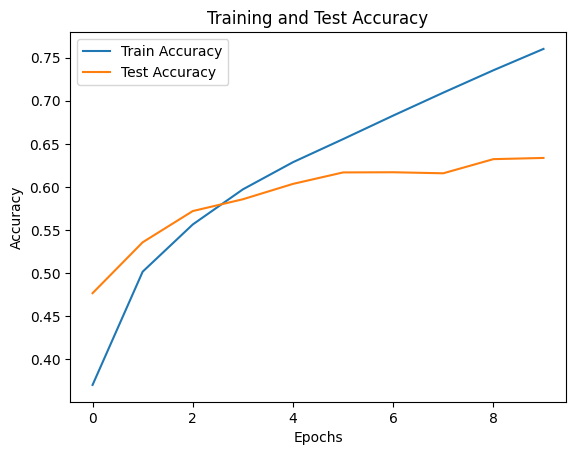

In [82]:
# Plot accuracy
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Test Accuracy")
plt.show()

In [89]:
import random

In [84]:
len(test_dataset)

10000

In [85]:
test_dataset[0][0].unsqueeze(dim=0).shape

torch.Size([1, 3, 32, 32])

In [86]:
test_dataset[0][0] / 2 + 0.5

tensor([[[0.6196, 0.6235, 0.6471,  ..., 0.5373, 0.4941, 0.4549],
         [0.5961, 0.5922, 0.6235,  ..., 0.5333, 0.4902, 0.4667],
         [0.5922, 0.5922, 0.6196,  ..., 0.5451, 0.5098, 0.4706],
         ...,
         [0.2667, 0.1647, 0.1216,  ..., 0.1490, 0.0510, 0.1569],
         [0.2392, 0.1922, 0.1373,  ..., 0.1020, 0.1137, 0.0784],
         [0.2118, 0.2196, 0.1765,  ..., 0.0941, 0.1333, 0.0824]],

        [[0.4392, 0.4353, 0.4549,  ..., 0.3725, 0.3569, 0.3333],
         [0.4392, 0.4314, 0.4471,  ..., 0.3725, 0.3569, 0.3451],
         [0.4314, 0.4275, 0.4353,  ..., 0.3843, 0.3725, 0.3490],
         ...,
         [0.4863, 0.3922, 0.3451,  ..., 0.3804, 0.2510, 0.3333],
         [0.4549, 0.4000, 0.3333,  ..., 0.3216, 0.3216, 0.2510],
         [0.4196, 0.4118, 0.3490,  ..., 0.3020, 0.3294, 0.2627]],

        [[0.1922, 0.1843, 0.2000,  ..., 0.1412, 0.1412, 0.1294],
         [0.2000, 0.1569, 0.1765,  ..., 0.1216, 0.1255, 0.1333],
         [0.1843, 0.1294, 0.1412,  ..., 0.1333, 0.1333, 0.

In [88]:
def predict_and_plot_grid(model,
                          dataset,
                          classes,
                          grid_size=3):
    model.eval()
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(9, 9))
    for i in range(grid_size):
        for j in range(grid_size):
            idx = random.randint(0, len(dataset) - 1)
            img, true_label = dataset[idx]
            input_tensor = img.unsqueeze(dim=0).to(device)
            with torch.inference_mode():
                output = model(input_tensor)
                _, predicted = torch.max(output.data, 1)
            img = img / 2 + 0.5 # Unormalize our images to be able to plot them with matplotlib
            npimg = img.cpu().numpy()
            axes[i, j].imshow(np.transpose(npimg, (1, 2, 0)))
            truth = classes[true_label] == classes[predicted.item()]
            if truth:
                color = "g"
            else:
                color = "r"

            axes[i, j].set_title(f"Truth: {classes[true_label]}\n, Predicted: {classes[predicted.item()]}", fontsize=10, c=color)
            axes[i, j].axis("off")
    plt.tight_layout()
    plt.show()

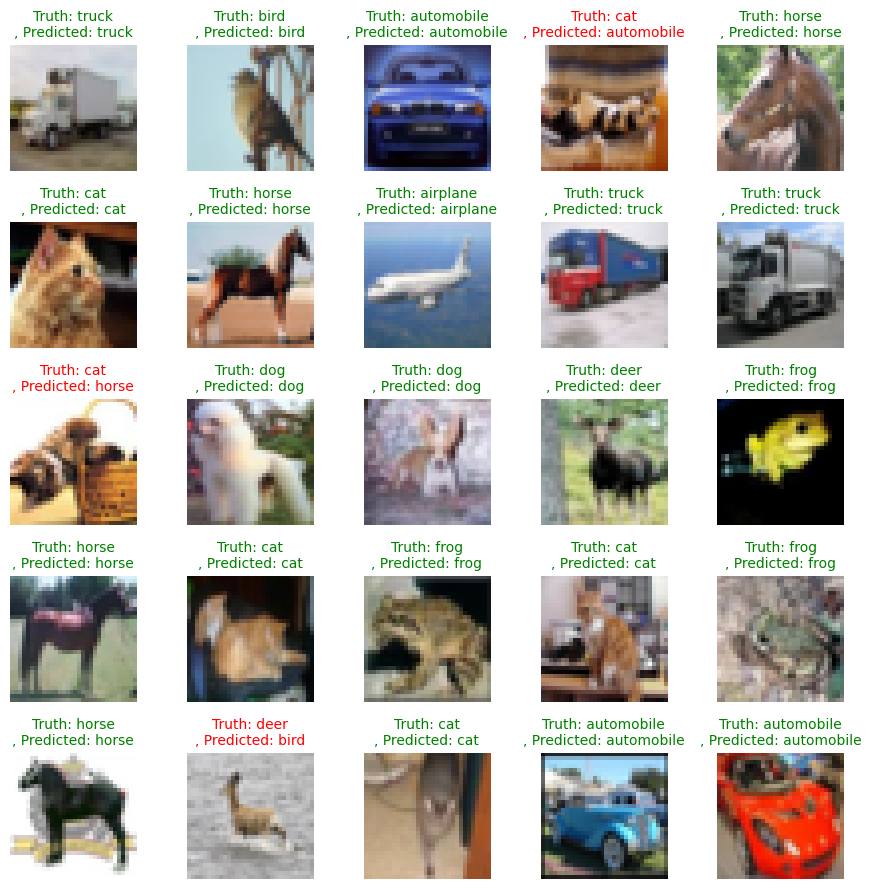

In [93]:
# prompt: use the fucntion predict_and_plot_grid

classes = train_dataset.classes
predict_and_plot_grid(model=model,
                      dataset=test_dataset,
                      classes=classes,
                      grid_size=5)